# Traffic stops at Rhode Island

## Table of contents
1. [Introduction](#introduction)
2. [Data cleaning](#cleaning)
    1. [Removing missing data](#missing)
    2. [Using proper datatypes](#converting)
3. [Exploratory data analysis (EDA)](#eda)



## Introduction <a name="introduction"></a>

This project uses data from ["The Stanford open policing project"](https://openpolicing.stanford.edu/) to analyse traffic stops by police officers in the Rhode Island State of the United States. After cleaning the data, several questions are answered by analysing it and by using visualisation tools. In particular, we are interested in analysing the impact of gender and race on the police behaviour. 

In addition, we combine this dataset with weather information from the ["National Centers for Environmental Information"](https://www.ncei.noaa.gov/) in order to understand how the weather conditions impact the police behaviour.



In [1]:
import pandas as pd

# Read input data and create a dataframe
input_file = 'data/ri_statewide_2020_04_01.csv'

ri = pd.read_csv(input_file, low_memory=False) #low_memory=False turns down a warning about some columns having mixed datatypes. This will be fixed later.



## Data cleaning <a name="cleaning"></a>

The first objective is to get the data ready to be analysed. We start by dropping columns with a large fraction of missing data as well as columns that have only 1 unique value. Rows with a significant fraction of missing data will be dropped as well. The acceptable thresholds for missing data will be decided after inspecting the dataset. 

Next, we look at the datatypes to check wether there is any column that would be more appropriate to be stored with a different dataype. For example, it is common that some of the columns that should be booleans or integers are stored as strings. This makes it easier to process the data in later steps. 

### Removing missing data <a name="missing"></a>

In [2]:
# Number of rows and columns
print(ri.shape)

(509681, 31)


In [3]:
# % of missing data in each column
print(100*ri.isnull().sum()/len(ri.index))

raw_row_number            0.000000
date                      0.001962
time                      0.001962
zone                      0.001962
subject_race              5.704156
subject_sex               5.708865
department_id             0.001962
type                      0.000000
arrest_made               5.704156
citation_issued           5.704156
warning_issued            5.704156
outcome                   7.032046
contraband_found         96.515075
contraband_drugs         96.863136
contraband_weapons       97.685807
contraband_alcohol       99.761223
contraband_other         96.515075
frisk_performed           0.001962
search_conducted          0.000000
search_basis             96.515075
reason_for_search        96.515075
reason_for_stop           5.704156
vehicle_make             37.585078
vehicle_model            54.856469
raw_BasisForStop          5.704156
raw_OperatorRace          5.704156
raw_OperatorSex           5.704156
raw_ResultOfStop          5.704156
raw_SearchResultOne 

Often, a DataFrame will contain columns that are not useful to your analysis. Such columns should be dropped from the DataFrame, to make it easier for you to focus on the remaining columns.

We will drop columns with more than 90% of missing data as well as columns that have only 1 unique value.

In [4]:
missing_data = 100*ri.isnull().sum()/len(ri.index)
missing_90 = [index for index, value in missing_data.items() if value > 90 ]
print("Dropping: ", missing_90)
ri.drop(missing_90, axis='columns', inplace=True)

Dropping:  ['contraband_found', 'contraband_drugs', 'contraband_weapons', 'contraband_alcohol', 'contraband_other', 'search_basis', 'reason_for_search', 'raw_SearchResultOne', 'raw_SearchResultTwo', 'raw_SearchResultThree']


In [5]:
print(ri.shape)

(509681, 21)


In [6]:
# Find % of unique values
unique_data = ri.nunique()
print(unique_data==1)

raw_row_number      False
date                False
time                False
zone                False
subject_race        False
subject_sex         False
department_id       False
type                 True
arrest_made         False
citation_issued     False
warning_issued      False
outcome             False
frisk_performed     False
search_conducted    False
reason_for_stop     False
vehicle_make        False
vehicle_model       False
raw_BasisForStop    False
raw_OperatorRace    False
raw_OperatorSex     False
raw_ResultOfStop    False
dtype: bool


In [7]:
print(ri['type'])

0         vehicular
1         vehicular
2         vehicular
3         vehicular
4         vehicular
            ...    
509676    vehicular
509677    vehicular
509678    vehicular
509679    vehicular
509680    vehicular
Name: type, Length: 509681, dtype: object


The 'type' column has one unique value 'vehicular'. This doesn't add any new information, so we drop that column too.

In [8]:
ri.drop(['type'], axis='columns', inplace=True)

In [9]:
print(ri.shape)

(509681, 20)


Our current dataframe contains 20 columns. Let's also remove rows for which more than 10 columns are NaN.

In [10]:
missing_columns = ri.isnull().sum(axis=1)
missing_10 = [index for index, value in missing_columns.items() if value > 10]
print(len(missing_10))
ri.drop(index=missing_10, inplace=True)

29073


### Using proper data types <a name="converting"></a>

In [11]:
# Look at the current datatypes
ri.dtypes

raw_row_number       int64
date                object
time                object
zone                object
subject_race        object
subject_sex         object
department_id       object
arrest_made         object
citation_issued     object
warning_issued      object
outcome             object
frisk_performed     object
search_conducted      bool
reason_for_stop     object
vehicle_make        object
vehicle_model       object
raw_BasisForStop    object
raw_OperatorRace    object
raw_OperatorSex     object
raw_ResultOfStop    object
dtype: object

Most of the columns have an <code>object</code> datatype, which means they are stored as string. Let's have a look at what type of values they contain to check wether another datatype would be more suitable.

In [12]:
for col in ri:
    print(col, ri[col].dtype)
    print("\t",ri[col].unique())

raw_row_number int64
	 [     1      2      3 ... 509678 509679 509680]
date object
	 ['2005-11-22' '2005-10-01' '2005-09-11' ... '2015-12-06' '2015-12-24'
 '2015-12-25']
time object
	 ['11:15:00' '12:20:00' '12:30:00' ... '05:39:00' '04:58:00' '05:23:00']
zone object
	 ['X3' 'X4' 'K3' 'K2' 'K1' 'X1']
subject_race object
	 ['white' 'hispanic' 'black' 'other' 'asian/pacific islander']
subject_sex object
	 ['male' 'female' nan]
department_id object
	 ['200' '500' '300' '900' '600' '000' '202' '502' '203' '003' '004' '009'
 '001' '002' '006' '505' '409' '402' '204' '205' '405' '506' '403' '411'
 '303' 'MA' '406' '415' '301' '501' '503' '20' '410' 'OUT' '201' '408'
 'K2' '304' '305' '508' '120' '413' '102' '407' '412' '416' '30' '509']
arrest_made object
	 [False True]
citation_issued object
	 [True False]
warning_issued object
	 [False True]
outcome object
	 ['citation' nan 'arrest' 'warning']
frisk_performed object
	 [False True]
search_conducted bool
	 [False  True]
reason_for_stop objec

By inspecting the unique types of each column it seems reasonable that the following columns, which have an object type (which usually means a string) should be changed to:

* date: object -> datetime
* time: object -> datetime
* zone: object -> categorical (6 different values)
* subject_race: object -> categorical (5 different values)
* subject_sex: object -> categorical/boolean
* arrest_made: object -> boolean
* citation_issued: object -> boolean
* warning_issued: object -> boolean
* outcome: object -> categorical (3 different values)
* frisk_performed: object -> boolean
* reason_for_stop: object -> categorical (12 different values)
* raw_OperatorRace: object -> categorical (7 different values)
* raw_OperatorSex: object -> categorical (4 different values)
* raw_ResultOfStop: object -> categorical (6 different values)


In [13]:
# Objetc to bool:
object_to_bool = ['arrest_made','citation_issued','warning_issued','frisk_performed']
ri[object_to_bool] = ri[object_to_bool].astype(bool)

In [14]:
# date and time to datetime. Make it also the index!
combined = ri['date'].str.cat(ri['time'], sep=' ')
ri['datetime'] = pd.to_datetime(combined)
ri.set_index('datetime', inplace=True)
ri.drop(['time'], axis='columns', inplace=True)
# We don't drop the date column since it will be useful later when we merge it with the weather dataset.

In [15]:
# Object to category
object_to_category = ['zone','subject_race','subject_sex','outcome','reason_for_stop','raw_OperatorRace','raw_OperatorSex','raw_ResultOfStop']
ri[object_to_category] = ri[object_to_category].astype("category")


In [16]:
# Check the new datatype
print(ri.dtypes)

raw_row_number         int64
date                  object
zone                category
subject_race        category
subject_sex         category
department_id         object
arrest_made             bool
citation_issued         bool
warning_issued          bool
outcome             category
frisk_performed         bool
search_conducted        bool
reason_for_stop     category
vehicle_make          object
vehicle_model         object
raw_BasisForStop      object
raw_OperatorRace    category
raw_OperatorSex     category
raw_ResultOfStop    category
dtype: object


# Exploratory data analysis (EDA) <a name="eda"></a>

In [17]:
for col in ri.columns:
    if col == 'raw_row_number': continue
    print(col)
    print(ri[col].value_counts(normalize=True))

date
2006-05-21    0.000612
2015-09-05    0.000608
2005-11-05    0.000589
2012-01-08    0.000578
2012-01-07    0.000572
                ...   
2005-08-09    0.000002
2005-04-04    0.000002
2005-01-23    0.000002
2005-09-16    0.000002
2005-09-15    0.000002
Name: date, Length: 3803, dtype: float64
zone
X4    0.261488
K3    0.226536
K2    0.202414
X3    0.186091
K1    0.095956
X1    0.027515
Name: zone, dtype: float64
subject_race
white                     0.717287
black                     0.142692
hispanic                  0.110537
asian/pacific islander    0.026687
other                     0.002796
Name: subject_race, dtype: float64
subject_sex
male      0.727128
female    0.272872
Name: subject_sex, dtype: float64
department_id
500    0.268608
300    0.229384
900    0.197487
200    0.174494
600    0.089668
000    0.031221
304    0.002283
203    0.001920
408    0.001696
202    0.001352
502    0.000556
201    0.000185
402    0.000183
204    0.000171
405    0.000110
305    0.000089
40

## One dimensional studies

## Comparing reason for stop by gender

In [18]:
# Create a DataFrame of female drivers
female = ri[ri['subject_sex']=='female']

# Create a DataFrame of male drivers
male = ri[ri['subject_sex']=='male']

# Compute the arrests by female drivers (as proportions)
print(female['reason_for_stop'].value_counts(normalize=True))

# Compute the arrests by male drivers (as proportions)
print(male['reason_for_stop'].value_counts(normalize=True))

Speeding                            0.657308
Other Traffic Violation             0.136581
Equipment/Inspection Violation      0.107055
Registration Violation              0.043077
Seatbelt Violation                  0.027071
Call for Service                    0.018057
Special Detail/Directed Patrol      0.005071
Motorist Assist/Courtesy            0.002532
Violation of City/Town Ordinance    0.001647
APB                                 0.000831
Suspicious Person                   0.000564
Warrant                             0.000206
Name: reason_for_stop, dtype: float64
Speeding                            0.522364
Other Traffic Violation             0.206948
Equipment/Inspection Violation      0.135102
Registration Violation              0.040581
Special Detail/Directed Patrol      0.037136
Seatbelt Violation                  0.036555
Call for Service                    0.014987
Violation of City/Town Ordinance    0.002347
Motorist Assist/Courtesy            0.001880
APB              

## Comparing speeding outcomes by gender

In [19]:
# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = ri[(ri['subject_sex']=='female') & (ri['reason_for_stop']=='Speeding')]

# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = ri[(ri['subject_sex']=='male') & (ri['reason_for_stop']=='Speeding')]

# Compute the stop outcomes for female drivers (as proportions)
print(female_and_speeding['outcome'].value_counts(normalize=True))

# Compute the stop outcomes for male drivers (as proportions)
print(male_and_speeding['outcome'].value_counts(normalize=True))

citation    0.954609
warning     0.039059
arrest      0.006332
Name: outcome, dtype: float64
citation    0.946763
warning     0.036167
arrest      0.017070
Name: outcome, dtype: float64


## Calculate the search rate

In [20]:
# Check the data type of 'search_conducted'
print(ri.search_conducted.dtype)

# Calculate the search rate by counting the values
print(ri.search_conducted.value_counts(normalize=True))

# Calculate the search rate by taking the mean
print(ri.search_conducted.mean())

bool
False    0.963043
True     0.036957
Name: search_conducted, dtype: float64
0.03695735401824356


In [21]:
# Calculate the search rate for female drivers
print(ri[ri['subject_sex']=='female'].search_conducted.mean())

# Calculate the search rate for male drivers
print(ri[ri['subject_sex']=='male'].search_conducted.mean())

# Calculate the search rate for both groups simultaneously
print(ri.groupby('subject_sex').search_conducted.mean())

0.018751239152648355
0.04379217389811301
subject_sex
female    0.018751
male      0.043792
Name: search_conducted, dtype: float64


## Adding a second factor to the analysis

In [22]:
# Calculate the search rate for each combination of gender and violation
print(ri.groupby(['reason_for_stop','subject_sex']).search_conducted.mean())

reason_for_stop                   subject_sex
APB                               female         0.165138
                                  male           0.255319
Call for Service                  female         0.042230
                                  male           0.092419
Equipment/Inspection Violation    female         0.040245
                                  male           0.070916
Motorist Assist/Courtesy          female         0.033133
                                  male           0.089802
Other Traffic Violation           female         0.038021
                                  male           0.059156
Registration Violation            female         0.054700
                                  male           0.103589
Seatbelt Violation                female         0.017746
                                  male           0.031705
Special Detail/Directed Patrol    female         0.018045
                                  male           0.010249
Speeding                  

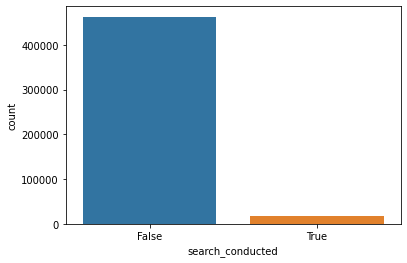

In [23]:
#TO DO
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='search_conducted', data=ri)
plt.show()

## Arrest per daytime

In [24]:
print(ri.columns)

# Calculate the overall arrest rate
print(ri['arrest_made'].mean())

# Calculate the hourly arrest rate
print(ri.groupby(ri.index.hour)['arrest_made'].mean())

# Save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour)['arrest_made'].mean()

Index(['raw_row_number', 'date', 'zone', 'subject_race', 'subject_sex',
       'department_id', 'arrest_made', 'citation_issued', 'warning_issued',
       'outcome', 'frisk_performed', 'search_conducted', 'reason_for_stop',
       'vehicle_make', 'vehicle_model', 'raw_BasisForStop', 'raw_OperatorRace',
       'raw_OperatorSex', 'raw_ResultOfStop'],
      dtype='object')
0.034545825287968575
datetime
0     0.052142
1     0.067121
2     0.061063
3     0.052604
4     0.053897
5     0.032657
6     0.012948
7     0.013829
8     0.019714
9     0.024698
10    0.025582
11    0.027078
12    0.031359
13    0.030248
14    0.031529
15    0.032124
16    0.033519
17    0.038989
18    0.039898
19    0.031366
20    0.039292
21    0.059956
22    0.043980
23    0.045084
Name: arrest_made, dtype: float64


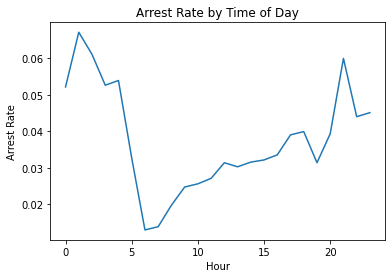

In [25]:
# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

# Display the plot
plt.show()

## Are searches on the rise?

datetime
2005-12-31    0.050688
2006-12-31    0.037747
2007-12-31    0.041844
2008-12-31    0.039542
2009-12-31    0.049848
2010-12-31    0.042086
2011-12-31    0.037762
2012-12-31    0.032277
2013-12-31    0.029054
2014-12-31    0.030155
2015-12-31    0.027828
Freq: A-DEC, Name: search_conducted, dtype: float64


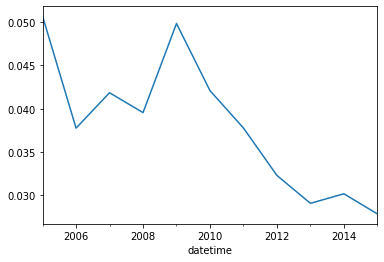

In [26]:
# Calculate the annual rate of performed searches
print(ri['search_conducted'].resample('A').mean())

# Save the annual rate of performed searches
annual_search_rate = ri['search_conducted'].resample('A').mean()

# Create a line plot of 'annual_drug_rate'
annual_search_rate.plot()

# Display the plot
plt.show()

## Does the search rate decrease translate into a arrest decrease as well?

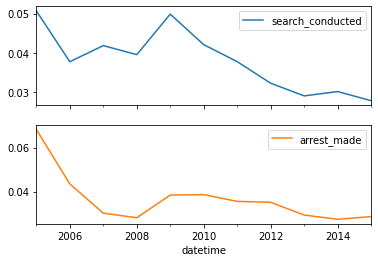

In [27]:
# Calculate and save the annual arrest rate
annual_arrest_rate = ri['arrest_made'].resample('A').mean()

# Concatenate 'annual_search_rate' and 'annual_arrest_rate'
annual = pd.concat([annual_search_rate,annual_arrest_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True)

# Display the subplots
plt.show()

## What violations are caught in each district?

In [28]:
# Create a frequency table of districts and violations
print(pd.crosstab(ri['zone'], ri['reason_for_stop']))

# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(ri['zone'], ri['reason_for_stop'])

# Select rows 'Zone K1' through 'Zone K3'
print(all_zones.loc['K1':'K3'])

# Save the smaller table as 'k_zones'
k_zones = all_zones.loc['K1':'K3']

reason_for_stop  APB  Call for Service  Equipment/Inspection Violation  \
zone                                                                     
K1                32               282                            3788   
K2               101              1036                           11285   
K3               144              1230                           12959   
X1                 6               198                            1725   
X3                64              1328                           11520   
X4               138              3535                           19975   

reason_for_stop  Motorist Assist/Courtesy  Other Traffic Violation  \
zone                                                                 
K1                                     78                     7130   
K2                                    118                    16440   
K3                                    258                    16218   
X1                                     33                

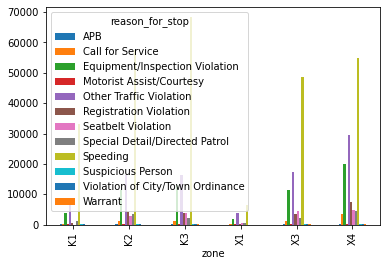

In [29]:
# Create a bar plot of 'all_zones'
all_zones.plot(kind='bar')

# Display the plot
plt.show()

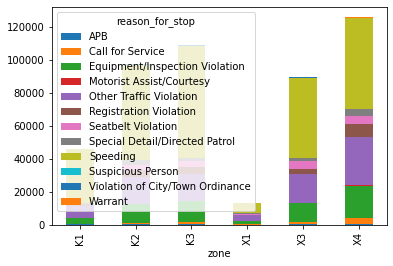

In [30]:
# Create a stacked bar plot of 'all_zones'
all_zones.plot(kind='bar', stacked=True)

# Display the plot
plt.show()

# Adding weather data

We now use weather daata from a different dataset to understand if weather conditions affect the police stops. For that, we use weather data from the National Center for Environmental Information collected at the Rhode Island weather station, USW00014765 (https://www.ncei.noaa.gov/) and (https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/).

In [31]:
weather_file = 'data/USW00014765.csv'

wd = pd.read_csv(weather_file, usecols=[1,2,3], names=['date', 'metric','value'])

print(wd.head())

       date metric  value
0  19420801   TAVG    240
1  19420802   TAVG    222
2  19420803   TAVG    247
3  19420804   TAVG    207
4  19420805   TAVG    188


In [32]:
weather=wd.pivot(index='date', columns='metric', values='value')

# Convert index to datetime format and make it the index
#weather['date'] = pd.to_datetime(weather.index)

In [33]:
ws = weather.loc[20050101:20181231]

In [34]:
def convert_tenths_to_celsius(tf):
    tf = tf/10.0
    return tf

ws[['TMIN','TAVG','TMAX']] = ws[['TMIN','TAVG','TMAX']].apply(convert_tenths_to_celsius)

/Users/laubana/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


metric         TMIN         TAVG         TMAX
count   5113.000000  2313.000000  5113.000000
mean       6.480325    11.528534    16.359476
std        9.447401     9.731215    10.121332
min      -22.700000   -17.600000   -11.000000
25%       -1.000000     3.900000     8.300000
50%        6.700000    11.900000    16.700000
75%       14.400000    20.100000    25.000000
max       25.000000    29.900000    38.900000


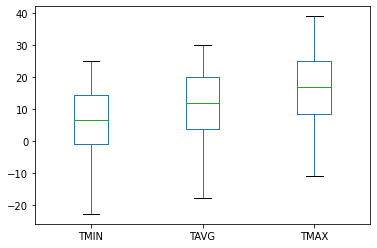

In [35]:
# Inspect the temperature columns 
# Describe the temperature columns
print(ws[['TMIN','TAVG','TMAX']].describe())

# Create a box plot of the temperature columns
ws[['TMIN','TAVG','TMAX']].plot(kind='box')

# Display the plot
plt.show()

<ipython-input-36-d9341482935e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['TDIFF'] = ws['TMAX']-ws['TMIN']


count    5113.000000
mean        9.879151
std         3.509849
min         1.100000
25%         7.700000
50%        10.000000
75%        12.200000
max        23.900000
Name: TDIFF, dtype: float64


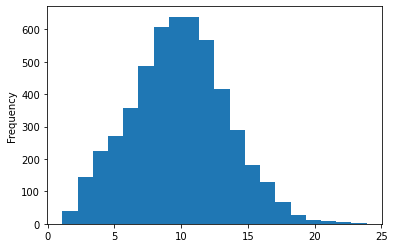

In [36]:
# Create a 'TDIFF' column that represents temperature difference
ws['TDIFF'] = ws['TMAX']-ws['TMIN']

# Describe the 'TDIFF' column
print(ws['TDIFF'].describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
ws['TDIFF'].plot(kind='hist', bins=20)

# Display the plot
plt.show()

In [37]:
print(ws['WT01'].unique())

[ 1. nan]


### Counting bad weather conditions

The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

* WT05 indicates "Hail"
* WT11 indicates "High or damaging winds"
* WT17 indicates "Freezing rain"
For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

In this exercise, you'll quantify "how bad" the weather was each day by counting the number of 1 values in each row.

<ipython-input-38-58b8434bbc4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['bad_conditions'] = WT.sum(axis='columns')
<ipython-input-38-58b8434bbc4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['bad_conditions'] = ws.bad_conditions.fillna(0).astype('int')


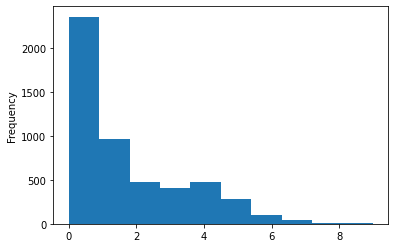

In [38]:
# Copy 'WT01' through 'WT22' to a new DataFrame
WT = ws.loc[:,'WT01':'WT22']

# Calculate the sum of each row in 'WT'
ws['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
ws['bad_conditions'] = ws.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
ws['bad_conditions'].plot(kind='hist')

# Display the plot
plt.show()

### Rating the weather conditions
In the previous exercise, you counted the number of bad weather conditions each day. In this exercise, you'll use the counts to create a rating system for the weather.

The counts range from 0 to 9, and should be converted to ratings as follows:

* Convert 0 to 'good'
* Convert 1 through 4 to 'bad'
* Convert 5 through 9 to 'worse'

In [39]:
# Count the unique values in 'bad_conditions' and sort the index
print(ws.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad',4:'bad',5:'worse',6:'worse',7:'worse',8:'worse',9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
ws['rating'] = ws.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(ws['rating'].value_counts())

0    2356
1     965
2     477
3     403
4     478
5     283
6     102
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
good     2356
bad      2323
worse     434
Name: rating, dtype: int64


<ipython-input-39-e63b5b4697b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['rating'] = ws.bad_conditions.map(mapping)


In [40]:
# Create a list of weather ratings in logical order
cats = ['good','bad','worse']

# Change the data type of 'rating' to category
cat_type = pd.Categorical(ws['rating'], categories=cats, ordered=True)

# Examine the head of 'rating'
print(ws['rating'].head())

date
20050101    bad
20050102    bad
20050103    bad
20050104    bad
20050105    bad
Name: rating, dtype: object


## Preparing the two dataframes to be merged

In [41]:
# Reset the index of 'ri' and 'ws'
ri.reset_index(inplace=True)
ws.reset_index(inplace=True)

# Examine the head of 'ri'
print(ri.head())

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = ws[['date','rating']]

# Examine the head of 'weather_rating'
print(weather_rating.head())

             datetime  raw_row_number        date zone subject_race  \
0 2005-11-22 11:15:00               1  2005-11-22   X3        white   
1 2005-10-01 12:20:00               2  2005-10-01   X3        white   
2 2005-10-01 12:30:00               3  2005-10-01   X3        white   
3 2005-10-01 12:50:00               4  2005-10-01   X3        white   
4 2005-10-01 13:10:00               5  2005-10-01   X3        white   

  subject_sex department_id  arrest_made  citation_issued  warning_issued  \
0        male           200        False             True           False   
1        male           200        False             True           False   
2      female           200        False             True           False   
3        male           200        False             True           False   
4      female           200        False             True           False   

    outcome  frisk_performed  search_conducted reason_for_stop vehicle_make  \
0  citation            False   

In [42]:
ri['date'] = pd.to_datetime(ri['date'])
weather_rating['date'] = pd.to_datetime(weather_rating['date'], format='%Y%m%d', errors='ignore')

<ipython-input-42-32c9f041977d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_rating['date'] = pd.to_datetime(weather_rating['date'], format='%Y%m%d', errors='ignore')


In [43]:
print(weather_rating.date)

0      2005-01-01
1      2005-01-02
2      2005-01-03
3      2005-01-04
4      2005-01-05
          ...    
5108   2018-12-27
5109   2018-12-28
5110   2018-12-29
5111   2018-12-30
5112   2018-12-31
Name: date, Length: 5113, dtype: datetime64[ns]


In [44]:
# Examine the shape of 'ri'
print(ri.shape)

# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, on='date', how='left')

# Examine the shape of 'ri_weather'
print(ri_weather.shape)

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('date', inplace=True)

(480608, 20)
(480608, 21)


In [45]:
print(ri_weather.head())

                      datetime  raw_row_number zone subject_race subject_sex  \
date                                                                           
2005-11-22 2005-11-22 11:15:00               1   X3        white        male   
2005-10-01 2005-10-01 12:20:00               2   X3        white        male   
2005-10-01 2005-10-01 12:30:00               3   X3        white      female   
2005-10-01 2005-10-01 12:50:00               4   X3        white        male   
2005-10-01 2005-10-01 13:10:00               5   X3        white      female   

           department_id  arrest_made  citation_issued  warning_issued  \
date                                                                     
2005-11-22           200        False             True           False   
2005-10-01           200        False             True           False   
2005-10-01           200        False             True           False   
2005-10-01           200        False             True           Fals

## Comparing arrest rates by weather rating
Do police officers arrest drivers more often when the weather is bad? Find out below!

* First, you'll calculate the overall arrest rate.
* Then, you'll calculate the arrest rate for each of the weather ratings you previously assigned.
* Finally, you'll add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate.
Since you previously defined a logical order for the weather categories, good < bad < worse, they will be sorted that way in the results.

In [46]:
# Calculate the overall arrest rate
print(ri_weather['arrest_made'].mean())

# Calculate the arrest rate for each 'rating'
print(ri_weather.groupby('rating')['arrest_made'].mean())

# Calculate the arrest rate for each 'violation' and 'rating'
print(ri_weather.groupby(['reason_for_stop','rating'])['arrest_made'].mean())

0.034545825287968575
rating
bad      0.035198
good     0.033002
worse    0.039357
Name: arrest_made, dtype: float64
reason_for_stop                   rating
APB                               bad       0.284314
                                  good      0.239496
                                  worse     0.372093
Call for Service                  bad       0.187269
                                  good      0.175385
                                  worse     0.177381
Equipment/Inspection Violation    bad       0.059704
                                  good      0.056480
                                  worse     0.094373
Motorist Assist/Courtesy          bad       0.103371
                                  good      0.116009
                                  worse     0.070175
Other Traffic Violation           bad       0.057973
                                  good      0.055618
                                  worse     0.062233
Registration Violation            bad       0.09